In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.827117169000303
GPU (s):
0.049472319000415155
GPU speedup over CPU: 57x


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import tensorflow as tf
import keras
stop_words= set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(stop_words)

{"that'll", 'most', 's', 'didn', 'were', 'then', 'such', 'will', 'while', 'needn', 'further', 'yourselves', 'had', 'his', 'my', "weren't", 'where', 'your', 'shan', 'with', "couldn't", 'why', 'ourselves', 'what', 'up', 'some', "don't", "wouldn't", 'aren', 'does', 'only', 'in', 'own', 'before', 'himself', 'being', 'haven', 'yours', 'or', 'through', 'm', 'mightn', 'their', 'more', 'our', 'all', 'having', 'myself', 'did', 'that', 'which', 'do', "you'd", 'how', 'don', 'o', 'shouldn', 'not', "mightn't", "won't", 'he', 'by', 'themselves', 'have', 'won', 'should', 'there', "wasn't", 'be', 'after', 'very', 'whom', 'wasn', 'hers', 'll', 'during', 'above', 'couldn', 'between', "you'll", 'itself', 'when', 'isn', 'they', 'of', 'been', 'until', 'ain', 'no', 'y', 'yourself', "hasn't", 'out', "you're", 'than', 'this', 'she', 'it', 'now', 'and', 'you', 'too', 'against', 'few', 'from', "isn't", 'them', 'am', "mustn't", 'was', 'off', 'here', 'doesn', 'hasn', "shan't", 'but', 'over', 'nor', 'those', 'must

In [ ]:
lemma =  WordNetLemmatizer()

news = pd.read_csv(r"/content/drive/My Drive/news (1).csv")

In [ ]:
news

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [ ]:
data=news.drop(['Unnamed: 0'],axis=1)

In [ ]:
data

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [ ]:
Y=[]

for i in range(len(data)):
    if data['label'].iloc[i] == 'FAKE':
        Y.append(1)
    elif data['label'].iloc[i] == 'REAL':
        Y.append(0)


In [ ]:
Y

[1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
TEXTdata=[]
TITLEdata=[]
for i in range(len(data)):
    data['text'].iloc[i] = re.sub('[^a-zA-Z]',' ',data['text'].iloc[i]).lower()
    data['title'].iloc[i] = re.sub('[^a-zA-Z]',' ',data['title'].iloc[i]).lower()
    
    textword = word_tokenize(data['text'].iloc[i])
    titleword = word_tokenize(data['title'].iloc[i])
    text=""
    title=""
    for w in textword:
        if w not in stop_words:
            wr = lemma.lemmatize(w)
            text=text+" "+wr
    for k in titleword:
        if k not in stop_words:
            kr = lemma.lemmatize(k)
            title=title+" "+kr
    TEXTdata.append(text)
    TITLEdata.append(title)  

In [ ]:
cv=TfidfVectorizer()
X=cv.fit_transform(TEXTdata).toarray()


In [ ]:
X.shape


(6335, 58026)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2) 

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024,input_shape=(X.shape[1],),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(512,input_shape=(1024,),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1024,input_shape=(512,),activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,input_shape=(1024,),activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(np.array(Xtrain),np.array(Ytrain),batch_size=64,epochs=100,validation_data=(np.array(Xtest),np.array(Ytest)),verbose=2)


Epoch 1/100
80/80 - 2s - loss: 0.3706 - accuracy: 0.8719 - val_loss: 0.6381 - val_accuracy: 0.7380
Epoch 2/100
80/80 - 1s - loss: 0.0713 - accuracy: 0.9745 - val_loss: 0.4959 - val_accuracy: 0.9140
Epoch 3/100
80/80 - 1s - loss: 0.0167 - accuracy: 0.9939 - val_loss: 0.3374 - val_accuracy: 0.9219
Epoch 4/100
80/80 - 1s - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.2817 - val_accuracy: 0.8903
Epoch 5/100
80/80 - 1s - loss: 0.0142 - accuracy: 0.9939 - val_loss: 0.1745 - val_accuracy: 0.9337
Epoch 6/100
80/80 - 1s - loss: 0.0192 - accuracy: 0.9921 - val_loss: 0.2212 - val_accuracy: 0.9148
Epoch 7/100
80/80 - 1s - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.2120 - val_accuracy: 0.9242
Epoch 8/100
80/80 - 1s - loss: 0.0124 - accuracy: 0.9963 - val_loss: 0.2115 - val_accuracy: 0.9361
Epoch 9/100
80/80 - 1s - loss: 0.0108 - accuracy: 0.9972 - val_loss: 0.2744 - val_accuracy: 0.9353
Epoch 10/100
80/80 - 1s - loss: 0.0189 - accuracy: 0.9959 - val_loss: 0.2836 - val_accuracy: 0.9361
Epoch 11/

Text(0.5, 0, 'epoch')

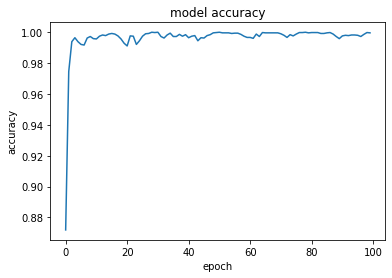

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

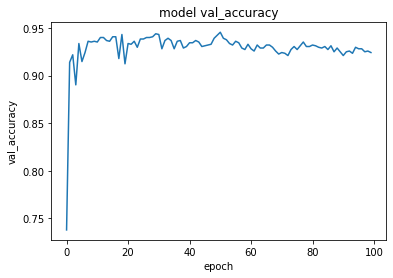

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.title('model val_accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

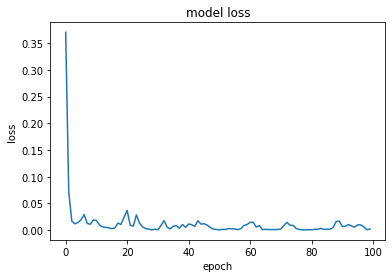

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

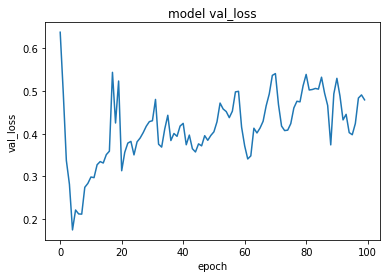

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.title('model val_loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')